In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split


In [ ]:
data = pd.read_csv('heart.csv')

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
data_cleaned = data.drop_duplicates()

In [ ]:
data_cleaned

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
733,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1
739,52,1,0,128,255,0,1,161,1,0.0,2,1,3,0
843,59,1,3,160,273,0,0,125,0,0.0,2,0,2,0


In [ ]:
rf = RandomForestClassifier()

In [ ]:
gb = GradientBoostingClassifier()

In [ ]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')

In [ ]:
    X = data_cleaned.drop('target', axis=1)
    y = data_cleaned['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


def load_clean_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data_cleaned = data.drop_duplicates()

    continuous_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    scaler = StandardScaler()
    data_cleaned[continuous_vars] = scaler.fit_transform(data_cleaned[continuous_vars])

    return data_cleaned, scaler


def model_pipeline():
    steps = [
        ('sampling', SMOTE()),
        ('ensemble', VotingClassifier(estimators=[
            ('rf', RandomForestClassifier()),
            ('gb', GradientBoostingClassifier())
        ], voting='soft'))
    ]

    pipeline = ImbPipeline(steps=steps)

    param_grid = {
        'ensemble__rf__n_estimators': [100, 200],
        'ensemble__rf__max_depth': [10, 20],
        'ensemble__gb__n_estimators': [100, 200],
        'ensemble__gb__learning_rate': [0.01, 0.1]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3)
    return grid_search

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return accuracy, report


def make_prediction(model, input_data, scaler, continuous_vars, feature_columns):
    input_data = pd.DataFrame([input_data], columns=feature_columns)
    input_data[continuous_vars] = scaler.transform(input_data[continuous_vars])
    prediction = model.predict(input_data)
    return prediction[0]

def main():
    file_path = 'heart.csv'
    heart_data, scaler = load_clean_preprocess_data(file_path)

    X = heart_data.drop('target', axis=1)
    y = heart_data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    pipeline = model_pipeline()
    pipeline.fit(X_train, y_train)

    accuracy, report = evaluate_model(pipeline, X_test, y_test)
    print(f"Model Accuracy: {accuracy}")
    print("Model Classification Report:")
    print(report)


    new_sample = [57, 1, 2, 130, 236, 0, 0, 174, 0, 0, 1, 1, 2]
    prediction = make_prediction(pipeline, new_sample, scaler, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], X.columns)
    print(f"Prediction for the new sample: {prediction}")

if __name__ == "__main__":
    main()


<ipython-input-20-9f81000fb98f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[continuous_vars] = scaler.fit_transform(data_cleaned[continuous_vars])


Model Accuracy: 0.8351648351648352
Model Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        48
           1       0.78      0.91      0.84        43

    accuracy                           0.84        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.84      0.84      0.83        91

Prediction for the new sample: 0


([<matplotlib.axis.XTick at 0x7d1f0fcd6620>,
 [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

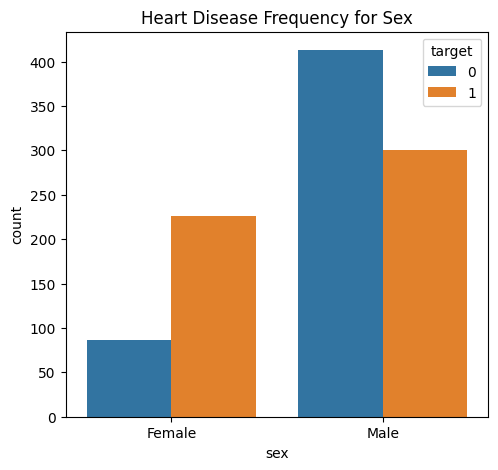

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='sex', hue='target', data=data)
plt.title('Heart Disease Frequency for Sex')
plt.xticks([0, 1], ['Female', 'Male'])

Text(0.5, 1.0, 'Heart Disease Distribution across Ages')

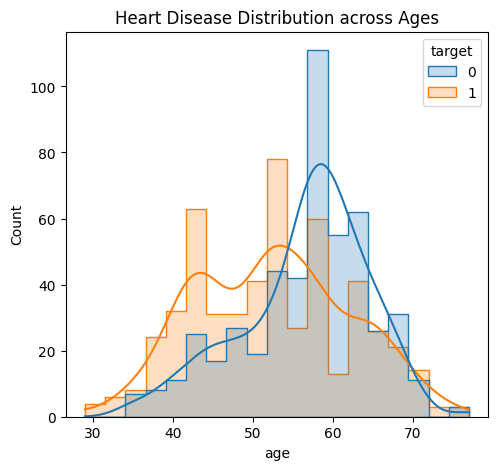

In [ ]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.histplot(data=data, x='age', hue='target', kde=True, element='step')
plt.title('Heart Disease Distribution across Ages')
